# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
df_train = pd.read_csv("./../../../datasets/competencia1_2022.csv")

Xtrain = df_train[df_train["foto_mes"] == 202101]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/tmp/ipykernel_210328/1192989844.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("./../../../datasets/competencia1_2022.csv")


In [9]:
Xtrain.mrentabilidad_annual.min()

-1286794.75

In [10]:
Xtrain.mrentabilidad_annual.max()

7941441.18

In [11]:
7941441.18 - -1286794.75

9228235.93

In [12]:
Xtrain.mrentabilidad_annual.describe()

count    1.613420e+05
mean     2.386081e+04
std      6.195241e+04
min     -1.286795e+06
25%      2.588903e+03
50%      1.315985e+04
75%      3.009550e+04
max      7.941441e+06
Name: mrentabilidad_annual, dtype: float64

In [8]:
Xtrain.mrentabilidad_annual.var()

3838101426.51067

In [5]:
1514/161342

0.0093837934325842

In [4]:
ytrain.value_counts()

0    159828
1      1514
Name: clase_ternaria, dtype: int64

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [3]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [4]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [5]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.805613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Y miramos su importancia de variables

In [6]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
5,cliente_edad,141
107,ctrx_quarter,126
8,mrentabilidad_annual,119
10,mactivos_margen,103
22,mcuentas_saldo,91
...,...,...
76,cforex_buy,0
75,cforex,0
70,mtarjeta_master_descuentos,0
69,ctarjeta_master_descuentos,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [7]:
import shap

/home/user/.local/share/virtualenvs/labo-a041pJnc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [9]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.004904,0.0,0.0,0.0,-0.002334,0.043758,0.013983,-0.041278,0.196130,0.000189,...,0.0,-0.000616,0.011454,-0.014267,-0.002817,-0.021265,0.0,-0.015299,0.0,-0.053038
1,-0.013970,0.0,0.0,0.0,-0.004382,0.048569,0.011794,0.006623,-0.096754,-0.011399,...,0.0,0.001421,-0.057956,-0.006672,0.011768,0.004617,0.0,-0.003721,0.0,-0.060725
2,-0.022926,0.0,0.0,0.0,-0.001292,-0.410950,0.011234,0.023368,0.058636,0.006585,...,0.0,0.001724,-0.030290,0.008067,-0.001562,-0.001833,0.0,-0.007120,0.0,0.016079
3,-0.018709,0.0,0.0,0.0,-0.002978,-0.213675,0.009803,-0.010034,-0.031874,-0.016405,...,0.0,0.001045,-0.000576,-0.014958,-0.003360,-0.063228,0.0,-0.000538,0.0,-0.111314
4,-0.012726,0.0,0.0,0.0,-0.002094,-0.203420,0.014232,-0.044485,0.168928,-0.012609,...,0.0,-0.002317,0.011874,-0.029288,-0.002845,-0.056215,0.0,-0.005447,0.0,-0.099260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.022436,0.0,0.0,0.0,-0.001274,0.045961,-0.071549,0.013633,-0.094009,-0.014529,...,0.0,0.001330,0.001324,-0.026429,-0.002340,0.062294,0.0,0.005572,0.0,0.079506
1510,0.014711,0.0,0.0,0.0,-0.002212,0.031978,-0.073241,0.003024,-0.105791,0.000905,...,0.0,0.001267,0.000154,-0.013291,0.011133,0.055093,0.0,0.003651,0.0,-0.071855
1511,0.015259,0.0,0.0,0.0,-0.002597,0.053010,-0.078954,0.022112,-0.120325,-0.005999,...,0.0,0.001442,0.000127,-0.011322,0.013452,0.080696,0.0,-0.000698,0.0,-0.128532
1512,0.005852,0.0,0.0,0.0,-0.003329,-0.179921,-0.070015,-0.004753,-0.104875,-0.015815,...,0.0,0.001135,-0.000063,-0.009317,0.012196,0.086014,0.0,-0.000202,0.0,-0.069681


Y consolidamos sus importancias

In [10]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter                     0.966983
cpayroll_trx                     0.611897
mtarjeta_visa_consumo            0.195651
mcuentas_saldo                   0.170158
mpasivos_margen                  0.141330
                                   ...   
cseguro_auto                     0.000000
cseguro_accidentes_personales    0.000000
mpayroll2                        0.000000
mcheques_emitidos_rechazados     0.000000
mforex_buy                       0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

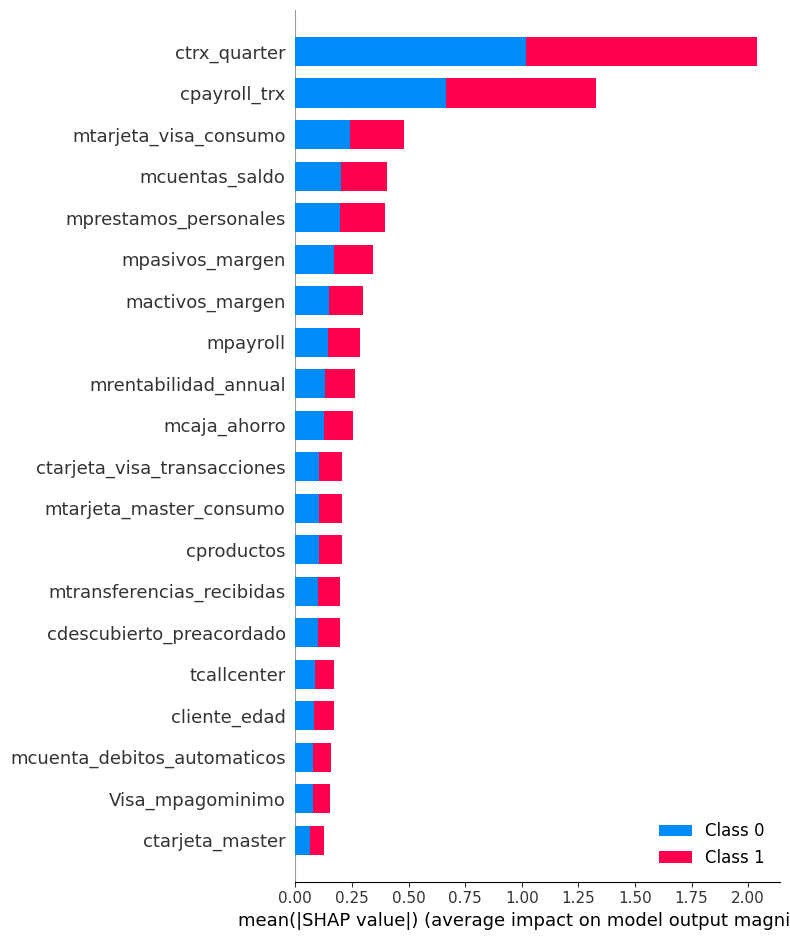

In [11]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

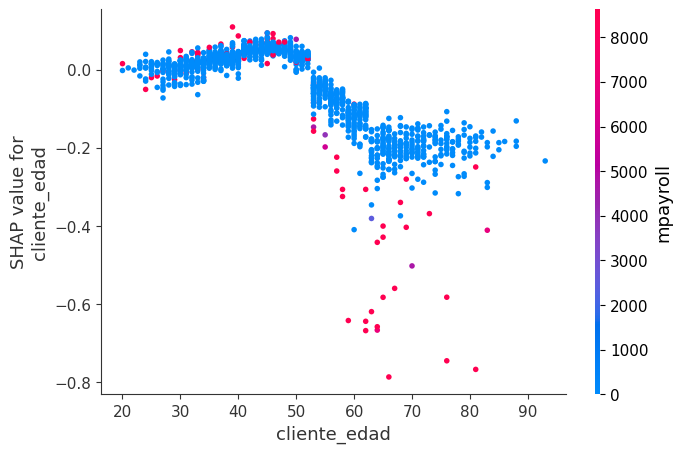

In [12]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [13]:
from umap import UMAP
import matplotlib.pyplot as plt


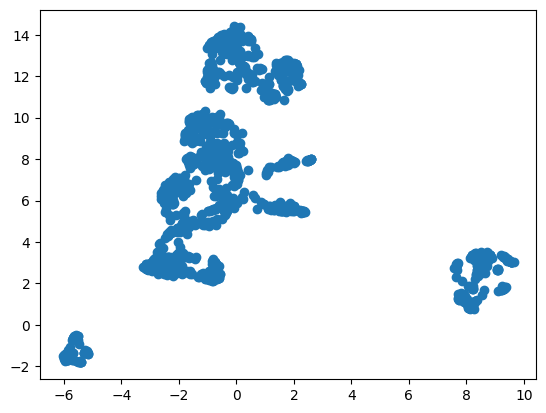

In [14]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [50]:
embedding_2d[0]

array([-1.2827605,  4.937288 ], dtype=float32)

In [53]:
embedding_2d = pd.DataFrame(embedding_2d)

In [57]:
embedding_2d = embedding_2d.add_prefix('umap_')

In [58]:
embedding_2d

,umap_0,umap_1
0,-1.282761,4.937288
1,8.507745,3.508048
2,-5.158104,-1.391712
3,0.065478,8.297538
4,1.536186,12.342137
...,...,...
1509,0.567902,11.729961
1510,1.547999,5.515666
1511,-1.633119,7.903657
1512,-0.834129,12.531159


In [67]:
Xbajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
26,31127916,202101,1,0,0,42,277,2649.44,30930.84,2519.56,...,0.0,11.0,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23
252,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,31328871,202101,1,0,0,83,293,335.32,17274.70,1699.39,...,0.0,25.0,48368.31,-44473.12,0.0,7490.0,2768.26,4.0,0.0,3964.74
443,31406150,202101,1,0,0,69,296,567.94,14262.98,1246.04,...,0.0,4.0,0.00,-13090.55,0.0,4772.0,0.00,0.0,0.0,0.00
509,31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,...,0.0,11.0,1777.09,-2250.51,0.0,5673.0,1759.50,1.0,0.0,82.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160869,206768061,202101,1,0,0,44,6,-303.88,2131.57,219.11,...,0.0,4.0,0.00,-1700.86,0.0,174.0,1053.97,1.0,0.0,7999.86
160905,206957932,202101,0,0,0,50,5,0.00,0.00,0.00,...,NaN,4.0,0.00,NaN,NaN,140.0,NaN,NaN,NaN,0.00
160932,207072528,202101,1,0,0,49,2,-79.20,284.25,-85.32,...,NaN,4.0,0.00,NaN,NaN,59.0,NaN,NaN,NaN,0.00
160945,207113408,202101,0,0,0,66,5,4018.70,6948.19,3905.97,...,NaN,4.0,0.00,NaN,NaN,133.0,NaN,NaN,NaN,0.00


In [89]:
Xbajas_umap = pd.concat([Xbajas.reset_index(),embedding_2d.reset_index()],axis=1)

In [69]:
Xbajas_umap

,index,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,...,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,index,umap_0,umap_1
0,26,31127916,202101,1,0,0,42,277,2649.44,30930.84,...,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23,0,-1.282761,4.937288
1,252,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8.507745,3.508048
2,322,31328871,202101,1,0,0,83,293,335.32,17274.70,...,-44473.12,0.0,7490.0,2768.26,4.0,0.0,3964.74,2,-5.158104,-1.391712
3,443,31406150,202101,1,0,0,69,296,567.94,14262.98,...,-13090.55,0.0,4772.0,0.00,0.0,0.0,0.00,3,0.065478,8.297538
4,509,31449517,202101,1,0,0,71,262,1248.52,17804.40,...,-2250.51,0.0,5673.0,1759.50,1.0,0.0,82.11,4,1.536186,12.342137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,160869,206768061,202101,1,0,0,44,6,-303.88,2131.57,...,-1700.86,0.0,174.0,1053.97,1.0,0.0,7999.86,1509,0.567902,11.729961
1510,160905,206957932,202101,0,0,0,50,5,0.00,0.00,...,NaN,NaN,140.0,NaN,NaN,NaN,0.00,1510,1.547999,5.515666
1511,160932,207072528,202101,1,0,0,49,2,-79.20,284.25,...,NaN,NaN,59.0,NaN,NaN,NaN,0.00,1511,-1.633119,7.903657
1512,160945,207113408,202101,0,0,0,66,5,4018.70,6948.19,...,NaN,NaN,133.0,NaN,NaN,NaN,0.00,1512,-0.834129,12.531159


Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [51]:
Xbajas_umap.head(1)

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,umap_0,umap_1
26,31127916.0,202101.0,1.0,0.0,0.0,42.0,277.0,2649.44,30930.84,2519.56,...,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23,-5.17834,-1.291859


In [15]:
from sklearn.cluster import DBSCAN

In [45]:
Xbajas_umap.filter(regex='^umap_',axis=1)['umap_0'].shape

(3013,)

In [153]:
labels = DBSCAN(eps=1.8).fit_predict(Xbajas_umap.filter(regex='^umap_',axis=1))
pd.Series(labels).value_counts()

0    1211
1     215
2      88
dtype: int64

In [154]:
Xbajas_umap['cluster'] = labels

In [72]:
Xbajas_umap['cluster']

0       0
1       1
2       2
3       0
4       3
       ..
1509    3
1510    0
1511    0
1512    3
1513    2
Name: cluster, Length: 1514, dtype: int64

In [85]:
from math import pi
from sklearn.preprocessing import StandardScaler


In [86]:
scaler = StandardScaler()

Xbajas_umap = scaler.fit_transform(Xbajas_umap)

In [155]:
Xbajas_umap_cats = Xbajas_umap[categories+['cluster']]

In [ ]:
Xbajas_umap

In [156]:
Xbajas_umap_cats[categories] = scaler.fit_transform(Xbajas_umap_cats[categories])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
Xbajas_umap_cats

,ctrx_quarter,cpayroll_trx,mtarjeta_visa_consumo,mcuentas_saldo,mprestamos_personales,mpasivos_margen,cluster
0,0.206074,-0.208478,-0.166751,-0.072350,-0.140534,-0.140290,0
1,-0.697543,-0.208478,-0.326621,-0.092351,-0.140534,-0.163541,1
2,2.148852,9.143695,2.245886,-0.056765,-0.140534,0.269306,2
3,-0.358687,-0.208478,-0.326621,-0.001882,-0.140534,-0.104972,0
4,-0.268325,-0.208478,-0.232947,-0.081583,-0.140534,-0.376092,3
...,...,...,...,...,...,...,...
1509,-0.268325,-0.208478,-0.270509,-0.125920,-0.140534,0.235563,3
1510,-0.697543,-0.208478,-0.326621,-0.077910,-0.140534,-0.163541,0
1511,-0.019830,-0.208478,-0.326621,-0.077366,-0.140534,-0.161308,0
1512,-0.652362,-0.208478,-0.326621,-0.088758,-0.140534,-0.163541,3


In [167]:
Xbajas_umap_cats.cluster.loc[Xbajas_umap_cats['cluster']==0].count(normalize=True)

TypeError: count() got an unexpected keyword argument 'normalize'

In [ ]:
Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==0].value_counts([])

In [164]:
str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==0].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'

'80.0%'

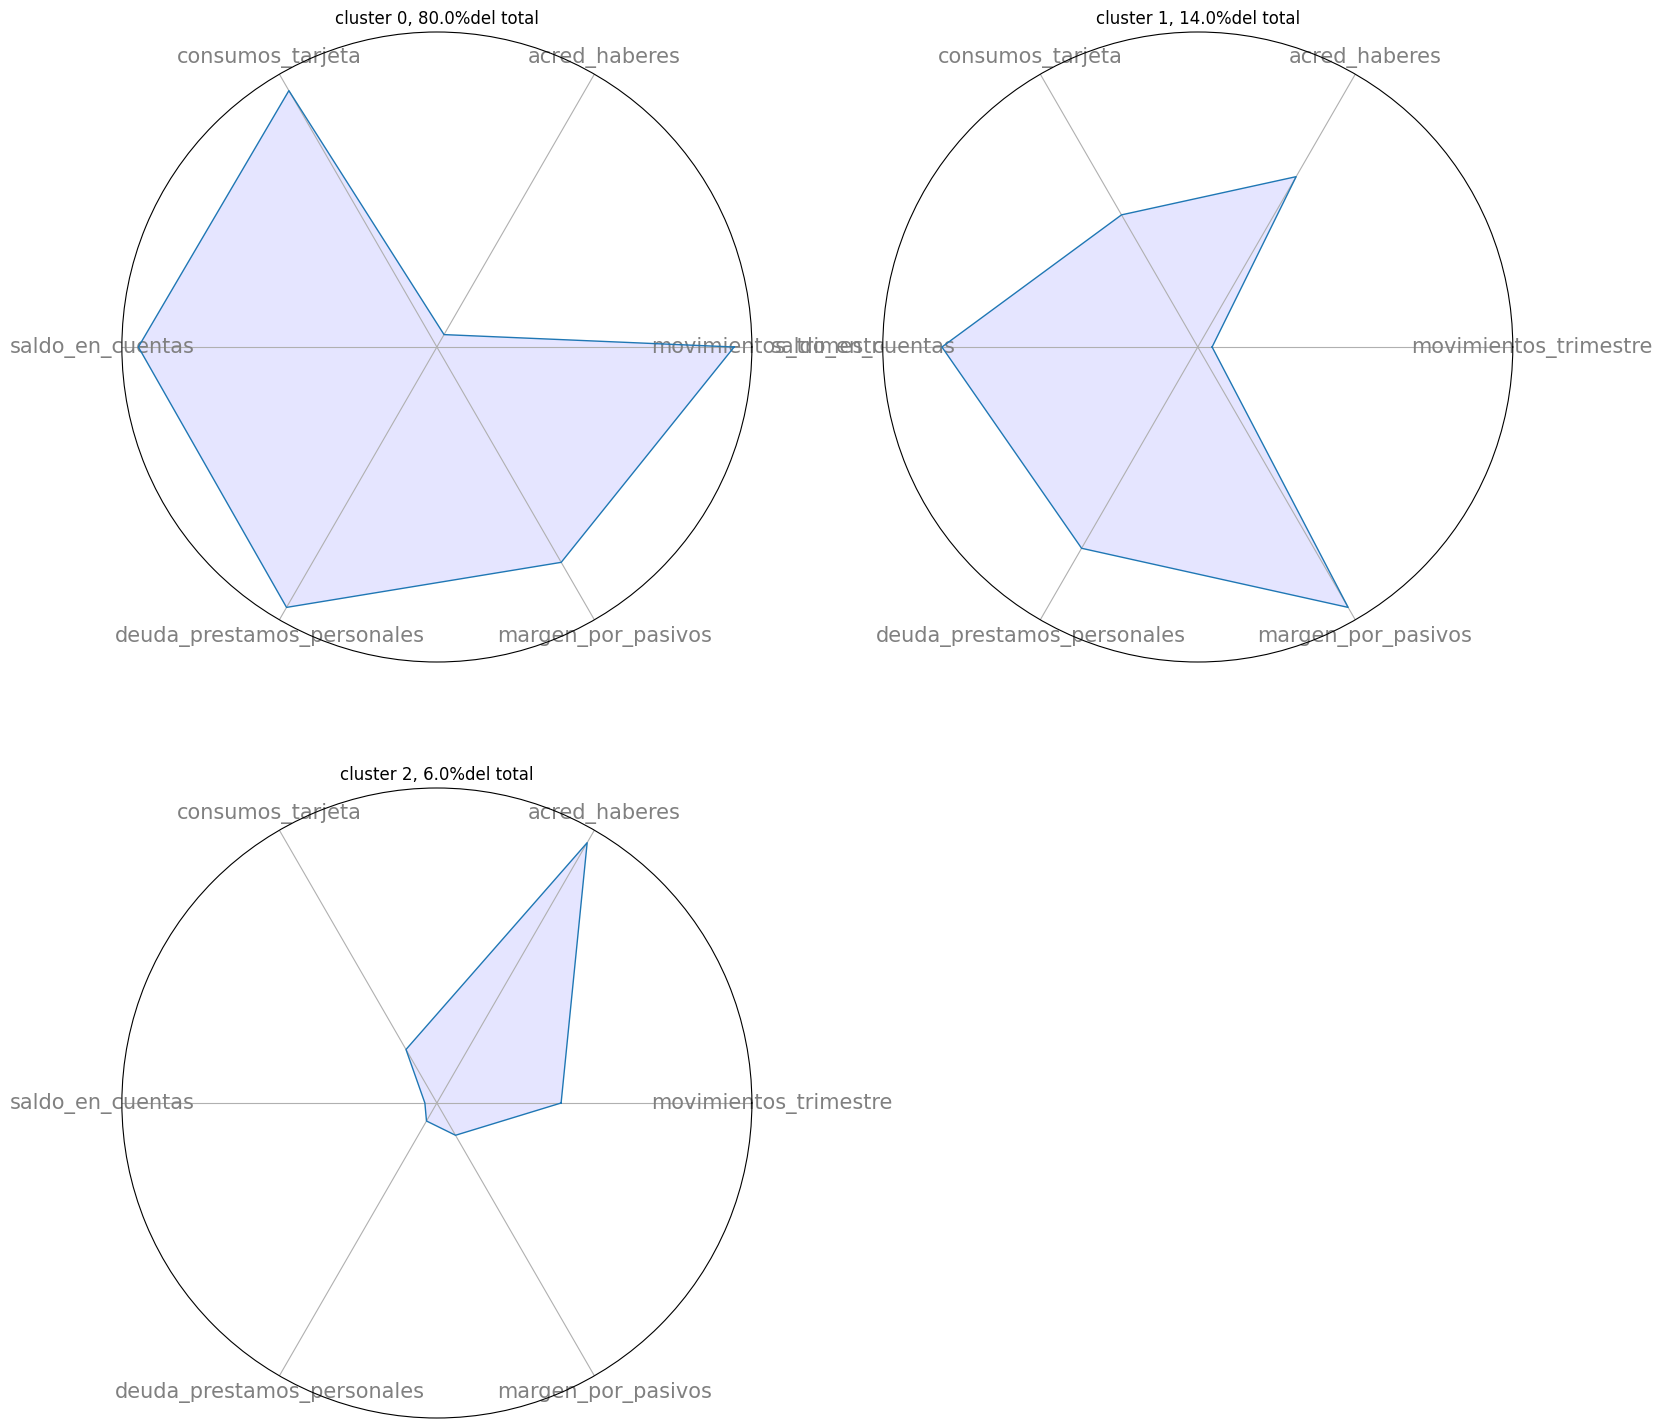

In [182]:
categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
N = len(categories)

fig = plt.figure(figsize=(18,18))


#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for i,cl in zip([221,222,223],range(3)):
    ax = fig.add_subplot(i, polar=True)
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    values

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
    categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
    plt.xticks(angles[:-1], categories_relabeled, color='grey', size=15)
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #ax.set_theta_offset(pi)
    prop = str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'
    ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
    #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

    plt.yticks([], [], color="grey", size=7)
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Show the graph
plt.show()

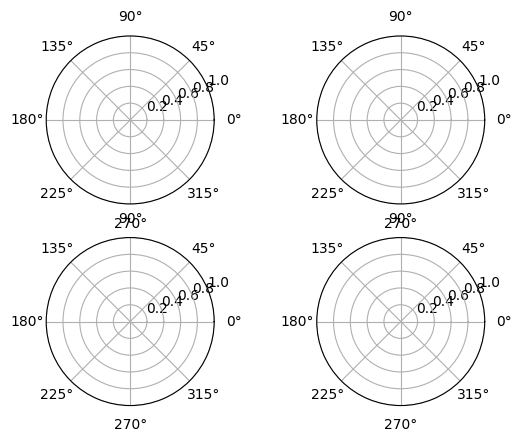

In [138]:
fig = plt.figure()

#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for i,cl in zip([221,222,223,224],range(4)):
    ax = fig.add_subplot(i, polar=True)
plt.show()

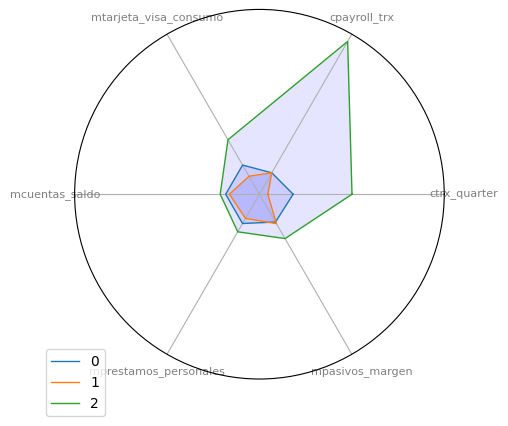

In [158]:
categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
N = len(categories)

ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories, color='grey', size=8)

ax.set_rlabel_position(0)
plt.yticks([], color="grey", size=7)


for cl in range(3):   
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    values

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid',label=cl)
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the graph
plt.show()

In [129]:
Xbajas_umap_cats.describe()

,ctrx_quarter,cpayroll_trx,mtarjeta_visa_consumo,mcuentas_saldo,mprestamos_personales,mpasivos_margen,cluster
count,1.514000e+03,1.514000e+03,1.514000e+03,1.514000e+03,1.514000e+03,1.514000e+03,1514.000000
mean,1.877260e-17,-1.055958e-17,4.693149e-17,4.693149e-18,3.519862e-18,-9.386298e-18,1.021136
std,1.000330e+00,1.000330e+00,1.000330e+00,1.000330e+00,1.000330e+00,1.000330e+00,1.273380
min,-6.975432e-01,-2.084781e-01,-3.266212e-01,-2.836490e+00,-1.405341e-01,-1.588277e+00,0.000000
25%,-6.297718e-01,-2.084781e-01,-3.266212e-01,-8.747894e-02,-1.405341e-01,-1.634427e-01,0.000000
50%,-3.360962e-01,-2.084781e-01,-3.266212e-01,-7.796786e-02,-1.405341e-01,-1.513528e-01,0.000000
75%,1.834839e-01,-2.084781e-01,-1.580941e-01,-6.997665e-02,-1.405341e-01,-7.233138e-02,3.000000
max,1.301485e+01,1.148174e+01,1.527232e+01,2.939467e+01,1.636353e+01,3.101070e+01,3.000000


In [121]:
    print(i,j,cl)

0 0 0
0 1 1
1 0 2
1 1 3


In [82]:
Xbajas_umap[categories].loc[0].values.flatten().tolist()

[40.0, 0.0, 3002.88, 2715.16, 0.0, 54.34]

[0.25505673381900584,
 -0.20847811041994643,
 0.13074968623392205,
 0.05267670965091147,
 0.07387743516484903,
 0.023851625317006825]

In [107]:
Xbajas_umap_cats[categories].loc[0].values.flatten().tolist()

[0.2060743217474013,
 -0.2084781104199464,
 -0.16675092399232308,
 -0.07235026210817241,
 -0.14053411353583659,
 -0.1402899215608779]